In [1]:
import os
import sys 
import math
# Import GPyTorch
import gpytorch

import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
from scipy import stats
from scipy.interpolate import interp1d
import time

import torch

# Import GPyTorch
import gpytorch

# Import exact GP model
# ExactGP is the base class for any exact-inference Gaussian process latent function
from gpytorch.models import ExactGP

# Import GPyTorch mean and covariance kernel functions
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, SpectralMixtureKernel

# Import GPyTorch distribution and likelihood
# MultivariateNormal a multivariate normal random variable
from gpytorch.distributions import MultivariateNormal
# GPyTorch likelihood specifies the mapping from latent function values observed labels
from gpytorch.likelihoods import GaussianLikelihood
# module that calculates the exact marginal log likelihood (MLL)
from gpytorch.mlls import ExactMarginalLogLikelihood
import tqdm




### Simulate data

In [6]:
np.random.seed(2020)

# generate weibull distribution parameter
shape=np.random.uniform(1,5,1000)
scale=np.random.uniform(0.5,2,1000)


# the full design matrix
x=np.c_[shape,scale]


y=(np.random.weibull(shape,size=1000)*scale)


train_x=x[:700,:]
train_y=y[:700]

test_x=x[700:,:]
test_y=y[700:]

ntrain=len(train_x)
ntest=len(test_x)



# Convert to PyTorch tensors and place
train_y = torch.from_numpy(train_y).float()
train_x = torch.from_numpy(train_x).float()
test_y = torch.from_numpy(test_y).float()
test_x = torch.from_numpy(test_x).float()

### GP Model

In [7]:
# Simple exact inference GP model with RBF kernel
# Inherit from GPyTorch's ExactGP base class
class RBFGP(ExactGP):
    # Exact GP initialization method
    def __init__(self, x_train, y_train, likelihood):        
        # Inherit from ExactGP
        super(RBFGP, self).__init__(x_train, y_train, likelihood)
        
        # Define mean and covariance functions
        self.mean = ConstantMean()
        self.cov = ScaleKernel(RBFKernel())

    # The forward method that takes in some n×d data x and returns a MultivariateNormal
    # with the prior mean and covariance evaluated at x
    def forward(self, x):
        # Get mean and covariance evaluated at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        
        # Multivariate normal object
        dist = MultivariateNormal(mean_x, cov_x)
        
        # Return multivariate normal object
        return dist

### Single Evaluation

In [8]:
# Instantiate likelihood and model
likelihood = GaussianLikelihood()
model = RBFGP(train_x, train_y, likelihood)
# "Loss" for GPs - the marginal log likelihood
# Takes likelihood and model instances as inputs
mll = ExactMarginalLogLikelihood(likelihood, model)

# Use the adam optimizer
# Model parameters includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define number of training epochs
n_epochs = 500

# Place model in training mode
model.train()
likelihood.train()

# Train GP model
print('\nTraining GP with RBF kernel...\n')
time_start = time.time()
for epoch in range(n_epochs):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x)
    
    # Calculate loss and backpropagate gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    # Display training progress
    if (((epoch + 1) % 200) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print('Epoch %03d | train loss: %s | length scale: %s | noise: %s' % 
              (epoch + 1, '{:.4f}'.format(loss.item()),
               '{:.4f}'.format(model.cov.base_kernel.lengthscale.item()),
               '{:.4f}'.format(model.likelihood.noise.item())))

# Model training complete
time_end = time.time()
print('\nGP training complete.')
print('Time to train:  %s\n' % ((time_end - time_start)))


# Place model and likelihood in evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad():
# Make predictions by feeding model through likelihood
    observed_pred = likelihood(model(test_x))

gprmu=observed_pred.mean.detach().numpy()
gprstd=observed_pred.stddev.detach().numpy()   



Training GP with RBF kernel...

Epoch 001 | train loss: 1.1356 | length scale: 0.7444 | noise: 0.6445
Epoch 200 | train loss: 1.0849 | length scale: 3.5390 | noise: 0.4948
Epoch 400 | train loss: 1.0847 | length scale: 4.6810 | noise: 0.4954
Epoch 500 | train loss: 1.0846 | length scale: 5.1135 | noise: 0.4955

GP training complete.
Time to train:  19.709321975708008



#### P(Y>1|X)

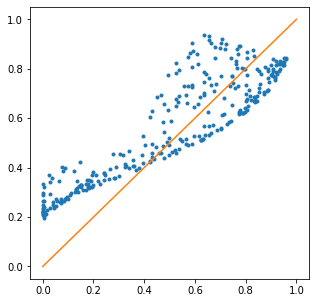

In [10]:
#true
tsuv1=1-stats.weibull_min.cdf(1,c=test_x[:,0],scale=test_x[:,1])

#cdf estimate by g
gprsuv1=1.-(stats.norm.cdf((1.-gprmu)/gprstd))

plt.figure(figsize=(5,5))
plt.plot(tsuv1,gprsuv1,'.')

plt.plot([0,1],[0,1])
np.save('gprsuv_est',gprsuv1)

#### Recovery of true cdf

In [11]:
#gdperate sample
np.random.seed(3421)
samps=np.random.choice(len(test_x),3)
yrange=np.linspace(-2,7,5000) #gaussian can go below 0

## mean and sd for gp sample
gprmusd=np.c_[gprmu,gprstd][samps]

In [13]:
gprmusd

array([[1.3291461 , 0.7056506 ],
       [0.7790992 , 0.70537585],
       [1.2631595 , 0.7050344 ]], dtype=float32)

/Users/tz/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


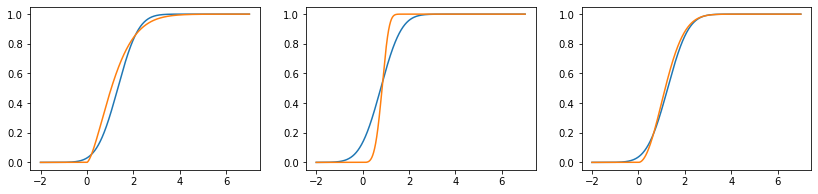

In [15]:
plt.figure(figsize=(14,3))
plt.subplot(131)

plt.subplot(1,3,1)
i=samps[0]
tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
gprcdf=stats.norm.cdf((yrange-gprmusd[0,0])/gprmusd[0,1])
plt.plot(yrange,gprcdf)
plt.plot(yrange,tcdf)

plt.subplot(1,3,2)
i=samps[1]
tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
gprcdf=stats.norm.cdf((yrange-gprmusd[1,0])/gprmusd[1,1])
plt.plot(yrange,gprcdf)
plt.plot(yrange,tcdf)

plt.subplot(1,3,3)
i=samps[2]
tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
gprcdf=stats.norm.cdf((yrange-gprmusd[2,0])/gprmusd[2,1])
plt.plot(yrange,gprcdf)
plt.plot(yrange,tcdf)

### Ten Replications to evaluate the hard metrics

In [16]:
##function to create replication
def rep_iter(x,y,frac=0.3):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [17]:
#initialize the metric
gprll=[]
gprcal=[]
gpr90=[]
gprmae=[]

In [19]:
np.random.seed(2021)
for a in range(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)
    ntrain=len(train_x)
    ntest=len(test_x)

    # Convert to PyTorch tensors and place
    train_y = torch.from_numpy(train_y).float()
    train_x = torch.from_numpy(train_x).float()
    test_x = torch.from_numpy(test_x).float()
    
    # Instantiate likelihood and model
    likelihood = GaussianLikelihood()
    model = RBFGP(train_x, train_y, likelihood)
    # "Loss" for GPs - the marginal log likelihood
    # Takes likelihood and model instances as inputs
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # Use the adam optimizer
    # Model parameters includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # Define number of training epochs
    n_epochs = 500

    # Place model in training mode
    model.train()
    likelihood.train()

    # Train GP model
    print('\nTraining GP with RBF kernel...\n')
    time_start = time.time()
    for epoch in range(n_epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()

        # Output from model
        output = model(train_x)

        # Calculate loss and backpropagate gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


    # Place model and likelihood in evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
    # Make predictions by feeding model through likelihood
        observed_pred = likelihood(model(test_x))

    gprmu=observed_pred.mean.detach().numpy()
    gprstd=observed_pred.stddev.detach().numpy()   


    
    
    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration

    gprc=[]

    for i in per:
        lquantile=(stats.norm.ppf(0.5-i/2.)*gprstd+gprmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*gprstd+gprmu)
        gprc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

    gprcal.append(np.abs(gprc-per).mean())
    
    #ninty
    l90=(stats.norm.ppf(0.5-0.9/2.)*gprstd+gprmu)
    r90=(stats.norm.ppf(0.5+0.9/2.)*gprstd+gprmu)
    gpr90.append(np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel())))
    
    #log likelihood
    low=np.quantile(test_y,0.05)
    high=np.quantile(test_y,0.95)
    itv=np.linspace(low,high,9)
    itv=np.append(-np.infty,itv)
    itv=np.append(itv,np.infty)
    #outcome1 belongs to which interval
    id=np.zeros(len(test_y))
    for i in range(10):
        id=id+1*(test_y.ravel()>itv[i+1])
    id=id.astype('int')

    l=(itv[id]-gprmu)/gprstd
    r=(itv[id+1]-gprmu)/gprstd
    prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
    ll_est=np.log(prtmp)
    gprll.append(ll_est.mean())
    
    #mae
    gprmae.append(np.abs(gprmu-stats.weibull_min.ppf(0.5,c=test_x[:,0],scale=test_x[:,1])).mean())
    
    




Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...



In [21]:
def musd(x):
    print(np.mean(x),np.std(x))

musd(gprll)
musd(gprcal)
musd(gpr90)
musd(gprmae)



-2.0961268714584103 0.04259918218224037
0.10337499999999995 0.02031475414842895
0.9380000000000001 0.014922019523732922
0.08184931975269426 0.012649811253985555
